In [40]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson, jarque_bera
import warnings
from itertools import combinations
from arch import arch_model
from statsmodels.tsa.vector_ar.vecm import coint_johansen, select_order, VECM
from statsmodels.tsa.vector_ar.var_model import VARProcess

# Konfiguracja
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Pobranie danych i logarytmy poziomów

[*********************100%***********************]  3 of 3 completed

POBIERANIE DANYCH – CZĘŚĆ B (logarytmy poziomów)


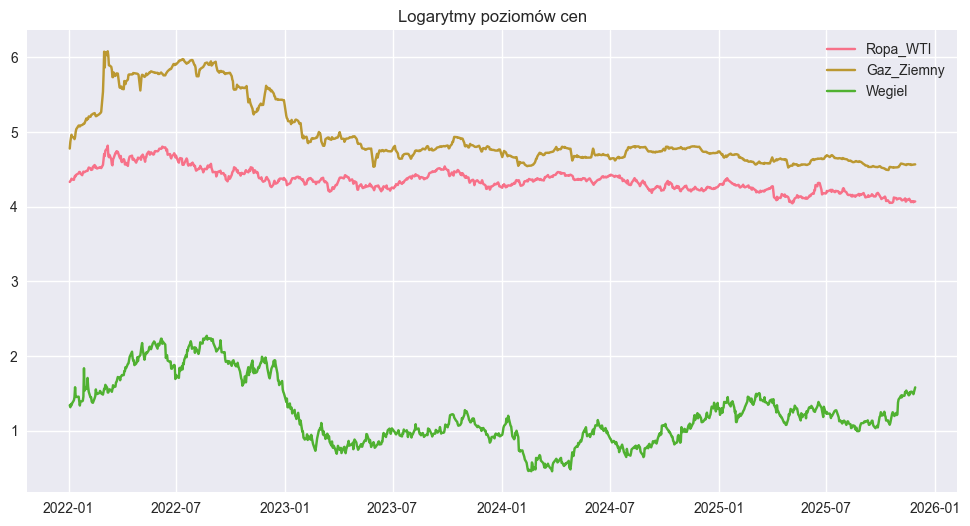


Podgląd logarytmów poziomów:
            Ropa_WTI  Gaz_Ziemny    Wegiel
Date                                      
2022-01-03  4.331785    4.779123  1.338941
2022-01-04  4.343676    4.867919  1.312917
2022-01-05  4.354784    4.922896  1.356350
2022-01-06  4.375254    4.963893  1.338154
2022-01-07  4.368181    4.930870  1.365071


In [41]:
print("POBIERANIE DANYCH – CZĘŚĆ B (logarytmy poziomów)")

tickers = ['CL=F', 'NG=F', 'MTF=F'] 
names   = ['Ropa_WTI', 'Gaz_Ziemny', 'Wegiel']

dane = yf.download(
    tickers,
    start='2022-01-01',
    end='2025-12-01',
    auto_adjust=False,
    threads=False,
    timeout=20
)['Adj Close']

dane.columns = names

log_dane = np.log(dane).dropna()

plt.figure(figsize=(12, 6))
for kol in log_dane.columns:
    plt.plot(log_dane[kol], label=kol)
plt.title('Logarytmy poziomów cen')
plt.legend()
plt.show()

print("\nPodgląd logarytmów poziomów:")
print(log_dane.head())


EDA dla logarytmów poziomów


ANALIZA EKSPLORACYJNA (EDA) – LOGARYTMY POZIOMÓW

Statystyki opisowe logarytmów poziomów:
                mean       std       min       max      skew  kurtosis
Ropa_WTI    4.351187  0.156626  4.045329  4.817859  0.582397  0.193488
Gaz_Ziemny  4.955110  0.437127  4.491441  6.083018  1.197319 -0.042026
Wegiel      1.231608  0.434964  0.454255  2.270062  0.642404 -0.410835


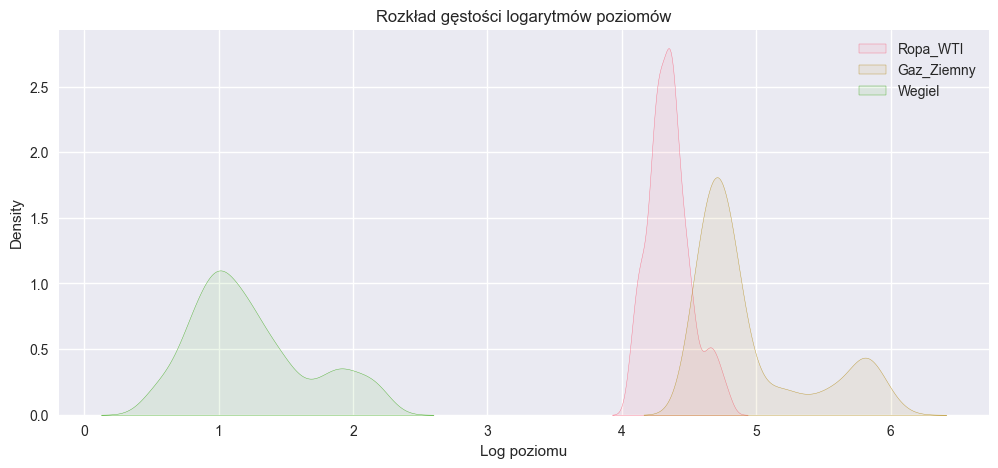

In [42]:
print("\nANALIZA EKSPLORACYJNA (EDA) – LOGARYTMY POZIOMÓW")

# Statystyki opisowe
desc_stats = log_dane.describe().T
desc_stats["skew"] = log_dane.skew()
desc_stats["kurtosis"] = log_dane.kurtosis()

print("\nStatystyki opisowe logarytmów poziomów:")
print(desc_stats[["mean", "std", "min", "max", "skew", "kurtosis"]])


# Histogramy + gęstości
plt.figure(figsize=(12, 5))
for col in log_dane.columns:
    sns.kdeplot(log_dane[col], label=col, fill=True, alpha=0.1)
plt.title("Rozkład gęstości logarytmów poziomów")
plt.xlabel("Log poziomu")
plt.legend()
plt.show()


Macierz korelacji

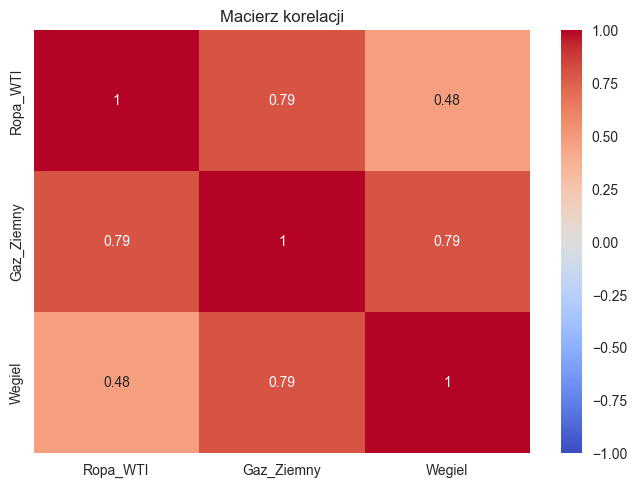

In [43]:
corr_matrix = log_dane.corr()
plot = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Macierz korelacji')
plt.show()

Testy ADF: sprawdzenie I(1)

In [44]:
print("\nTESTY STACJONARNOŚCI (ADF) DLA LOGARYTMÓW I ICH RÓŻNIC")

for kol in log_dane.columns:
    # poziom
    res_level = adfuller(log_dane[kol])
    # pierwsza różnica
    diff = log_dane[kol].diff().dropna()
    res_diff = adfuller(diff)
    
    print(f"\nZmienna: {kol}")
    print(f"  Poziom:      statystyka ADF = {res_level[0]:.4f}, wartość p = {res_level[1]:.4f}")
    print(f"  Pierwsza różnica: stat. ADF = {res_diff[0]:.4f}, wartość p = {res_diff[1]:.4f}")



TESTY STACJONARNOŚCI (ADF) DLA LOGARYTMÓW I ICH RÓŻNIC

Zmienna: Ropa_WTI
  Poziom:      statystyka ADF = -1.0534, wartość p = 0.7333
  Pierwsza różnica: stat. ADF = -12.8845, wartość p = 0.0000

Zmienna: Gaz_Ziemny
  Poziom:      statystyka ADF = -0.9744, wartość p = 0.7625
  Pierwsza różnica: stat. ADF = -7.9148, wartość p = 0.0000

Zmienna: Wegiel
  Poziom:      statystyka ADF = -1.4862, wartość p = 0.5403
  Pierwsza różnica: stat. ADF = -35.8378, wartość p = 0.0000


Test Johansena - liczba relacji kointegrujących

In [45]:
def johansen_test(df, k_ar_diff=2, det_order=0):
    """
    Test Johansena dla danych df.
    Zwraca obiekt wynikowy oraz rangę kointegracji (liczbę relacji).
    """
    wynik = coint_johansen(df, det_order, k_ar_diff)

    statystyki = wynik.lr1              # Statystyki śladu
    krytyczne = wynik.cvt[:, 1]         # Wartości krytyczne 5%
    ranga = int((statystyki > krytyczne).sum())

    return wynik, ranga


Kointegracja w parach

In [46]:
print("\nKOINTEGRACJA W PARACH (test Johansena)\n")

pary = list(combinations(log_dane.columns, 2))

for p in pary:
    df_para = log_dane[list(p)]

    wynik, ranga = johansen_test(df_para)

    status = "kointegracja WYSTĘPUJE" if ranga >= 1 else "kointegracja NIE występuje"

    print(f"\nPara: {p[0]} – {p[1]}")
    print(f"  Szacowana ranga kointegracji = {ranga}  →  {status}")
    print("  Statystyki śladu i wartości krytyczne (5%):")

    for i, (stat, crit) in enumerate(zip(wynik.lr1, wynik.cvt[:, 1])):
        print(f"    r <= {i}: stat = {stat:.4f}, kryt = {crit:.4f}")



KOINTEGRACJA W PARACH (test Johansena)


Para: Ropa_WTI – Gaz_Ziemny
  Szacowana ranga kointegracji = 1  →  kointegracja WYSTĘPUJE
  Statystyki śladu i wartości krytyczne (5%):
    r <= 0: stat = 16.8966, kryt = 15.4943
    r <= 1: stat = 1.4260, kryt = 3.8415

Para: Ropa_WTI – Wegiel
  Szacowana ranga kointegracji = 0  →  kointegracja NIE występuje
  Statystyki śladu i wartości krytyczne (5%):
    r <= 0: stat = 6.6144, kryt = 15.4943
    r <= 1: stat = 2.4121, kryt = 3.8415

Para: Gaz_Ziemny – Wegiel
  Szacowana ranga kointegracji = 0  →  kointegracja NIE występuje
  Statystyki śladu i wartości krytyczne (5%):
    r <= 0: stat = 7.9943, kryt = 15.4943
    r <= 1: stat = 1.4564, kryt = 3.8415


Kointegracji dla trzech instrumentów razem

In [47]:
print("\nKOINTEGRACJA DLA TRZECH INSTRUMENTÓW (Johansen)\n")

wynik3, ranga3 = johansen_test(log_dane)

status3 = "kointegracja WYSTĘPUJE" if ranga3 >= 1 else "kointegracja NIE występuje"

print(f"Ranga kointegracji (system 3-zmienny) = {ranga3}  →  {status3}")
print("Statystyki śladu i wartości krytyczne (5%):")

for i, (stat, crit) in enumerate(zip(wynik3.lr1, wynik3.cvt[:, 1])):
    print(f"  r <= {i}: stat = {stat:.4f}, kryt = {crit:.4f}")



KOINTEGRACJA DLA TRZECH INSTRUMENTÓW (Johansen)

Ranga kointegracji (system 3-zmienny) = 1  →  kointegracja WYSTĘPUJE
Statystyki śladu i wartości krytyczne (5%):
  r <= 0: stat = 32.9721, kryt = 29.7961
  r <= 1: stat = 4.6785, kryt = 15.4943
  r <= 2: stat = 1.5293, kryt = 3.8415


Estymacja VECM

In [48]:
print("\n=== WYBÓR OPOŹNIEŃ DO VECM ===")
lag_sel = select_order(log_dane, maxlags=15, deterministic="ci")
print(lag_sel.summary())

k_ar_diff = int(lag_sel.aic)
print(f"\nWybrane opóźnienie (k_ar_diff) = {k_ar_diff}")



=== WYBÓR OPOŹNIEŃ DO VECM ===
 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -20.40     -20.33*   1.376e-09     -20.38*
1       -20.42      -20.30   1.358e-09      -20.37
2      -20.42*      -20.26  1.350e-09*      -20.36
3       -20.42      -20.21   1.356e-09      -20.34
4       -20.42      -20.16   1.359e-09      -20.32
5       -20.41      -20.11   1.361e-09      -20.30
6       -20.42      -20.07   1.359e-09      -20.28
7       -20.41      -20.02   1.365e-09      -20.26
8       -20.40      -19.96   1.379e-09      -20.23
9       -20.40      -19.92   1.375e-09      -20.22
10      -20.39      -19.86   1.390e-09      -20.19
11      -20.39      -19.81   1.398e-09      -20.17
12      -20.38      -19.76   1.408e-09      -20.14
13      -20.37      -19.70   1.428e-09      -20.11
14      -20.36      -19.65   1.439e-09      -20.09
15      -20.35      -19.60   1.448e-09      -20.07

In [ ]:
vecm = VECM(
    log_dane,
    k_ar_diff=k_ar_diff,
    coint_rank=ranga3,
    deterministic="ci"
).fit()


print(vecm.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation Ropa_WTI
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.Ropa_WTI       0.0323      0.033      0.983      0.325      -0.032       0.097
L1.Gaz_Ziemny     0.0167      0.023      0.733      0.463      -0.028       0.062
L1.Wegiel         0.0285      0.015      1.911      0.056      -0.001       0.058
L2.Ropa_WTI      -0.0470      0.033     -1.430      0.153      -0.111       0.017
L2.Gaz_Ziemny     0.0421      0.023      1.851      0.064      -0.002       0.087
L2.Wegiel         0.0234      0.015      1.571      0.116      -0.006       0.053
Det. terms outside the coint. relation & lagged endog. parameters for equation Gaz_Ziemny
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1

Diagnostyka reszt modelu

In [ ]:

# --- A. AUTOKORELACJA (Multivariate Portmanteau) ---
print("\n[A] Test autokorelacji reszt")
whiteness_test = vecm.test_whiteness(nlags=10, adjusted=True)

print(f"Statystyka testu: {whiteness_test.test_statistic:.4f}")
print(f"P-value:          {whiteness_test.pvalue:.4f}")

if whiteness_test.pvalue > 0.05:
    print("WNIOSEK: Brak istotnej autokorelacji reszt.")
else:
    print("WNIOSEK: Istnieje autokorelacja reszt.")

# --- B. NORMALNOŚĆ (Multivariate Jarque-Bera) ---
print("\n[B] Test normalności rozkładu reszt")
normality_test = vecm.test_normality()

print(f"Statystyka testu: {normality_test.test_statistic:.4f}")
print(f"P-value:          {normality_test.pvalue:.4f}")

if normality_test.pvalue > 0.05:
    print("WNIOSEK: Reszty mają rozkład normalny.")
else:
    print("WNIOSEK: Brak normalności reszt.")

# --- C. HETEROSKEDASTYCZNOŚĆ (Efekt ARCH - test jednowymiarowy) ---
print("\n[C] Test na efekt ARCH (Warunkowa heteroskedastyczność)")
print(f"{'Zmienna':<15} | {'LM Stat':<10} | {'P-value':<10} | {'Wynik'}")
print("-" * 55)

resid_data = vecm.resid
names = vecm.names
arch_found = False

for i, name in enumerate(names):
    r = resid_data[:, i] if hasattr(resid_data, 'shape') else resid_data[name]
    
    lm_stat, p_val, f_stat, f_pval = het_arch(r)
    
    status = "ARCH obecne" if p_val < 0.05 else "OK"
    if p_val < 0.05:
        arch_found = True
        
    print(f"{name:<15} | {lm_stat:>10.4f} | {p_val:>10.4f} | {status}")

print("-" * 55)
if arch_found:
    print("WNIOSEK: Wykryto heteroskedastyczność w niektórych zmiennych.")
else:
    print("WNIOSEK: Wariancja reszt jest stabilna (homoskedastyczność).")


=== DIAGNOSTYKA RESZT MODELU VECM ===

[A] Test autokorelacji reszt
Statystyka testu: 109.6095
P-value:          0.0014
WNIOSEK: Istnieje autokorelacja reszt.

[B] Test normalności rozkładu reszt
Statystyka testu: 23356.2722
P-value:          0.0000
WNIOSEK: Brak normalności reszt.

[C] Test na efekt ARCH (Warunkowa heteroskedastyczność)
Zmienna         | LM Stat    | P-value    | Wynik
-------------------------------------------------------
Ropa_WTI        |   102.6427 |     0.0000 | ARCH obecne
Gaz_Ziemny      |   214.0464 |     0.0000 | ARCH obecne
Wegiel          |    58.2947 |     0.0000 | ARCH obecne
-------------------------------------------------------
WNIOSEK: Wykryto heteroskedastyczność w niektórych zmiennych.


In [ ]:
print("--- POSZUKIWANIE OPTYMALNEGO LAGU (ELIMINACJA AUTOKORELACJI) ---")

start_lag = vecm.k_ar 
max_lag_search = 15
best_model = None
found_clean_model = False
results_log = []

for p in range(start_lag, max_lag_search + 1):
    # k_ar_diff w VECM to p-1 z modelu VAR
    current_diff_lags = p - 1
    model_candidate = VECM(
                log_dane, 
                k_ar_diff=current_diff_lags, 
                coint_rank=1,
                deterministic="ci"
            )
    fitted_candidate = model_candidate.fit()
    
    whiteness_test = fitted_candidate.test_whiteness(nlags=12, adjusted=True)
    p_value = whiteness_test.pvalue
    stat = whiteness_test.test_statistic
    
    print(f"Lag (VAR): {p} | VECM_diff: {current_diff_lags} | Portmanteau p-value: {p_value:.4f}")
    
    results_log.append((p, p_value, fitted_candidate))

    # 3. Kryterium sukcesu
    if p_value > 0.05:
        print(f"  -> SUKCES! Znaleziono model bez autokorelacji przy Lagu={p}")
        best_results = fitted_candidate
        found_clean_model = True
        break

if found_clean_model:
    vecm = best_results
    print("\nModel zaktualizowany. Można bezpiecznie przejść do Grangera i IRF.")
else:
    print("\nNie udało się wyeliminować autokorelacji nawet przy 15 lagach.")

--- POSZUKIWANIE OPTYMALNEGO LAGU (ELIMINACJA AUTOKORELACJI) ---
Lag (VAR): 3 | VECM_diff: 2 | Portmanteau p-value: 0.0006
Lag (VAR): 4 | VECM_diff: 3 | Portmanteau p-value: 0.0008
Lag (VAR): 5 | VECM_diff: 4 | Portmanteau p-value: 0.0020
Lag (VAR): 6 | VECM_diff: 5 | Portmanteau p-value: 0.0081
Lag (VAR): 7 | VECM_diff: 6 | Portmanteau p-value: 0.0488
Lag (VAR): 8 | VECM_diff: 7 | Portmanteau p-value: 0.0843
  -> SUKCES! Znaleziono model bez autokorelacji przy Lagu=8

Model zaktualizowany. Można bezpiecznie przejść do Grangera i IRF.


In [52]:
print(vecm.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation Ropa_WTI
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.Ropa_WTI       0.0224      0.033      0.675      0.499      -0.043       0.087
L1.Gaz_Ziemny     0.0252      0.023      1.092      0.275      -0.020       0.071
L1.Wegiel         0.0247      0.015      1.651      0.099      -0.005       0.054
L2.Ropa_WTI      -0.0455      0.033     -1.380      0.168      -0.110       0.019
L2.Gaz_Ziemny     0.0451      0.023      1.958      0.050   -4.41e-05       0.090
L2.Wegiel         0.0195      0.015      1.292      0.196      -0.010       0.049
L3.Ropa_WTI      -0.0439      0.033     -1.333      0.183      -0.109       0.021
L3.Gaz_Ziemny    -0.0252      0.023     -1.085      0.278      -0.071       0.020
L3.Wegiel        -0.0073      0.015     -0.481      0.630      -0.037       0.022
L4.Ropa_WT

In [ ]:

# --- A. AUTOKORELACJA (Multivariate Portmanteau) ---
print("\n[A] Test autokorelacji reszt")
whiteness_test = vecm.test_whiteness(nlags=10, adjusted=True)

print(f"Statystyka testu: {whiteness_test.test_statistic:.4f}")
print(f"P-value:          {whiteness_test.pvalue:.4f}")

if whiteness_test.pvalue > 0.05:
    print("WNIOSEK: Brak istotnej autokorelacji reszt.")
else:
    print("WNIOSEK: Istnieje autokorelacja reszt.")

# --- B. NORMALNOŚĆ (Multivariate Jarque-Bera) ---
print("\n[B] Test normalności rozkładu reszt")
normality_test = vecm.test_normality()

print(f"Statystyka testu: {normality_test.test_statistic:.4f}")
print(f"P-value:          {normality_test.pvalue:.4f}")

if normality_test.pvalue > 0.05:
    print("WNIOSEK: Reszty mają rozkład normalny.")
else:
    print("WNIOSEK: Brak normalności reszt.")

# --- C. HETEROSKEDASTYCZNOŚĆ (Efekt ARCH - test jednowymiarowy) ---
print("\n[C] Test na efekt ARCH (Warunkowa heteroskedastyczność)")
print(f"{'Zmienna':<15} | {'LM Stat':<10} | {'P-value':<10} | {'Wynik'}")
print("-" * 55)

resid_data = vecm.resid
names = vecm.names
arch_found = False

for i, name in enumerate(names):
    r = resid_data[:, i] if hasattr(resid_data, 'shape') else resid_data[name]
    
    lm_stat, p_val, f_stat, f_pval = het_arch(r)
    
    status = "ARCH obecne" if p_val < 0.05 else "OK"
    if p_val < 0.05:
        arch_found = True
        
    print(f"{name:<15} | {lm_stat:>10.4f} | {p_val:>10.4f} | {status}")

print("-" * 55)
if arch_found:
    print("WNIOSEK: Wykryto heteroskedastyczność w niektórych zmiennych.")
else:
    print("WNIOSEK: Wariancja reszt jest stabilna (homoskedastyczność).")


=== DIAGNOSTYKA RESZT MODELU VECM ===

[A] Test autokorelacji reszt
Statystyka testu: 34.6941
P-value:          0.0731
WNIOSEK: Brak istotnej autokorelacji reszt.

[B] Test normalności rozkładu reszt
Statystyka testu: 23220.9341
P-value:          0.0000
WNIOSEK: Brak normalności reszt.

[C] Test na efekt ARCH (Warunkowa heteroskedastyczność)
Zmienna         | LM Stat    | P-value    | Wynik
-------------------------------------------------------
Ropa_WTI        |    83.0737 |     0.0000 | ARCH obecne
Gaz_Ziemny      |   229.0750 |     0.0000 | ARCH obecne
Wegiel          |   110.9190 |     0.0000 | ARCH obecne
-------------------------------------------------------
WNIOSEK: Wykryto heteroskedastyczność w niektórych zmiennych.


Stabilność systemu

Parametry strukturalne modelu:
  Liczba zmiennych (K): 3
  Rząd kointegracji (r): 1
  Oczekiwana liczba pierwiastków jednostkowych (K-r): 2
------------------------------------------------------------
Wyniki dekompozycji spektralnej:
  Znalezione pierwiastki jednostkowe (|λ| ≈ 1): 2
  Znalezione pierwiastki wybuchowe (|λ| > 1):   0
  Znalezione pierwiastki stabilne (|λ| < 1):    22
  Maksymalny moduł wartości własnej: 1.000000


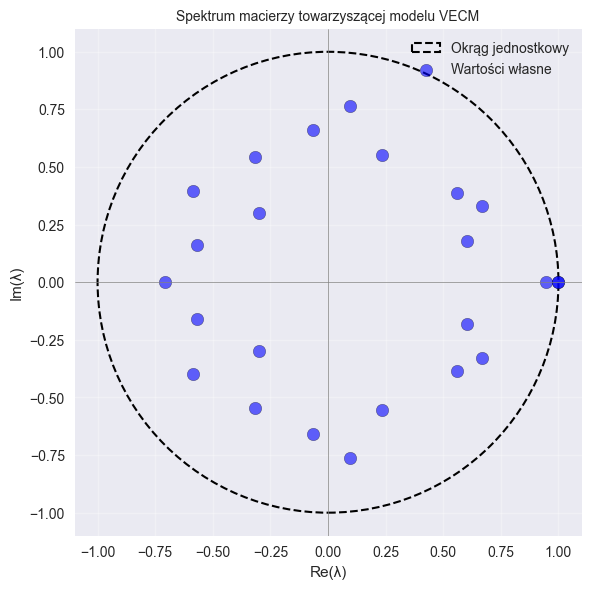

In [54]:
# ------------------------------------------------------------------------------
# Model VECM można przekształcić w model VAR na poziomach zmiennych.
# Stabilność oceniamy poprzez wartości własne macierzy towarzyszącej tego VAR.

# Pobranie macierzy współczynników A1...Ap
A_mats = vecm.var_rep  # shape: (p, k, k)
p = A_mats.shape[0]    # liczba opóźnień
k = A_mats.shape[1]    # liczba zmiennych


companion_matrix = np.zeros((k * p, k * p))
top_row = np.hstack([A_mats[i] for i in range(p)])
companion_matrix[:k, :] = top_row

# Bloki jednostkowe
if p > 1:
    companion_matrix[k:, :-k] = np.eye(k * (p - 1))

# Wartości własne
eigenvalues = np.linalg.eigvals(companion_matrix)
moduli = np.abs(eigenvalues)

# Sortowanie malejąco
sorted_idx = np.argsort(moduli)[::-1]
eigenvalues = eigenvalues[sorted_idx]
moduli = moduli[sorted_idx]

# 4. Parametry teoretyczne
r = vecm.coint_rank
expected_unit_roots = k - r
# Teoria VECM:
# Dla systemu K zmiennych i rzędu kointegracji r:
# 1. Dokładnie (K - r) wartości własnych powinno mieć moduł równy 1 (pierwiastki jednostkowe).
#    Odpowiadają one wspólnym trendom stochastycznym (Common Stochastic Trends).
# 2. Pozostałe wartości własne muszą mieć moduł < 1 (część stabilna).
# 3. Żadna wartość własna nie może mieć modułu > 1 (warunek braku eksplozji).

K = A_mats.shape[1]         # Liczba zmiennych endogenicznych
r = vecm.coint_rank    # Rząd kointegracji
expected_unit_roots = K - r
tolerance = 1e-5       # Tolerancja numeryczna 

# Klasyfikacja pierwiastków
n_unit = np.sum((moduli >= 1 - tolerance) & (moduli <= 1 + tolerance))
n_explosive = np.sum(moduli > 1 + tolerance)
n_stable = np.sum(moduli < 1 - tolerance)

# Prezentacja wyników
print(f"Parametry strukturalne modelu:")
print(f"  Liczba zmiennych (K): {K}")
print(f"  Rząd kointegracji (r): {r}")
print(f"  Oczekiwana liczba pierwiastków jednostkowych (K-r): {expected_unit_roots}")
print("-" * 60)
print(f"Wyniki dekompozycji spektralnej:")
print(f"  Znalezione pierwiastki jednostkowe (|λ| ≈ 1): {n_unit}")
print(f"  Znalezione pierwiastki wybuchowe (|λ| > 1):   {n_explosive}")
print(f"  Znalezione pierwiastki stabilne (|λ| < 1):    {n_stable}")
print(f"  Maksymalny moduł wartości własnej: {np.max(moduli):.6f}")

fig, ax = plt.subplots(figsize=(6, 6))

# Okrąg jednostkowy
unit_circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--', linewidth=1.5, label='Okrąg jednostkowy')
ax.add_patch(unit_circle)

# Wartości własne
ax.scatter(eigenvalues.real, eigenvalues.imag, color='blue', alpha=0.6, s=80, edgecolors='black', label='Wartości własne')

# Linie pomocnicze
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)

# Opis osi i tytuł
ax.set_xlabel('Re(λ)')
ax.set_ylabel('Im(λ)')
ax.set_title('Spektrum macierzy towarzyszącej modelu VECM', fontsize=10)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')

# Zakres osi (z marginesem)
limit = max(1.1, np.max(moduli) + 0.1)
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)

plt.tight_layout()
plt.show()

Parametry VECM – podgląd (α, β, Γ)

In [56]:
names = log_dane.columns.tolist()

print("\n=== PARAMETRY DŁUGOOKRESOWE (ALPHA – speed of adjustment) ===")
alpha_df = pd.DataFrame(vecm.alpha, index=names, columns=['ec1'])
print(alpha_df)

print("\n=== P-WARTOŚCI DLA ALPHA ===")
alpha_p = pd.DataFrame(vecm.pvalues_alpha, index=names, columns=['ec1'])
print(alpha_p)

print("\n=== RELACJA KOINTEGRACYJNA (BETA) ===")
beta = vecm.beta[:, 0]  # jedna relacja
beta_df = pd.Series(beta, index=names, name='beta')
print(beta_df)

# Możesz sobie wypisać relację w formie równania:
print("\nRelacja kointegracyjna w stylu:")
eq_str = " + ".join([f"{beta[i]:.4f} * {names[i]}" for i in range(len(names))])
print(f"ec1 = {eq_str} + const")



=== PARAMETRY DŁUGOOKRESOWE (ALPHA – speed of adjustment) ===
                 ec1
Ropa_WTI   -0.017608
Gaz_Ziemny  0.050702
Wegiel     -0.023576

=== P-WARTOŚCI DLA ALPHA ===
                 ec1
Ropa_WTI    0.034875
Gaz_Ziemny  0.000014
Wegiel      0.190072

=== RELACJA KOINTEGRACYJNA (BETA) ===
Ropa_WTI      1.000000
Gaz_Ziemny   -0.526306
Wegiel        0.271392
Name: beta, dtype: float64

Relacja kointegracyjna w stylu:
ec1 = 1.0000 * Ropa_WTI + -0.5263 * Gaz_Ziemny + 0.2714 * Wegiel + const


In [ ]:
print("\n=== KRÓTKOOKRESOWA PRZYCZYNOWOŚĆ (VECM) ===")

for zm in names:
    test = vecm.test_granger_causality(caused=zm)
    print(f"\nCzy inne zmienne wpływają krótkookresowo na {zm}?")
    print(test.summary())



=== KRÓTKOOKRESOWA PRZYCZYNOWOŚĆ (VECM) ===

Czy inne zmienne wpływają krótkookresowo na Ropa_WTI?
Granger causality F-test. H_0: ['Gaz_Ziemny', 'Wegiel'] do not Granger-cause Ropa_WTI. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         1.268          1.647   0.209 (16, 2835)
------------------------------------------------

Czy inne zmienne wpływają krótkookresowo na Gaz_Ziemny?
Granger causality F-test. H_0: ['Ropa_WTI', 'Wegiel'] do not Granger-cause Gaz_Ziemny. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         1.627          1.647   0.054 (16, 2835)
------------------------------------------------

Czy inne zmienne wpływają krótkookresowo na Wegiel?
Granger causality F-test. H_0: ['Ropa_WTI', 'Gaz_Ziemny'] do not Granger-cause Wegiel. Conclusion: fail to rej

In [58]:
print("\n=== DŁUGOOKRESOWA PRZYCZYNOWOŚĆ ===")
alpha = vecm.alpha[:, 0]

alpha_p = vecm.pvalues_alpha[:, 0]
for i, zm in enumerate(names):
    print(f"{zm}: alpha = {alpha[i]:.4f}, p-value = {alpha_p[i]:.4f}")


=== DŁUGOOKRESOWA PRZYCZYNOWOŚĆ ===
Ropa_WTI: alpha = -0.0176, p-value = 0.0349
Gaz_Ziemny: alpha = 0.0507, p-value = 0.0000
Wegiel: alpha = -0.0236, p-value = 0.1901



=== FUNKCJE ODPOWIEDZI NA IMPULS (IRF) ===
Macierz korelacji reszt:
            Ropa_WTI  Gaz_Ziemny    Wegiel
Ropa_WTI    1.000000    0.207225  0.094859
Gaz_Ziemny  0.207225    1.000000  0.030224
Wegiel      0.094859    0.030224  1.000000

Model przeliczony dla kolejności Cholesky'ego: ['Ropa_WTI', 'Gaz_Ziemny', 'Wegiel']


<Figure size 1200x1200 with 0 Axes>

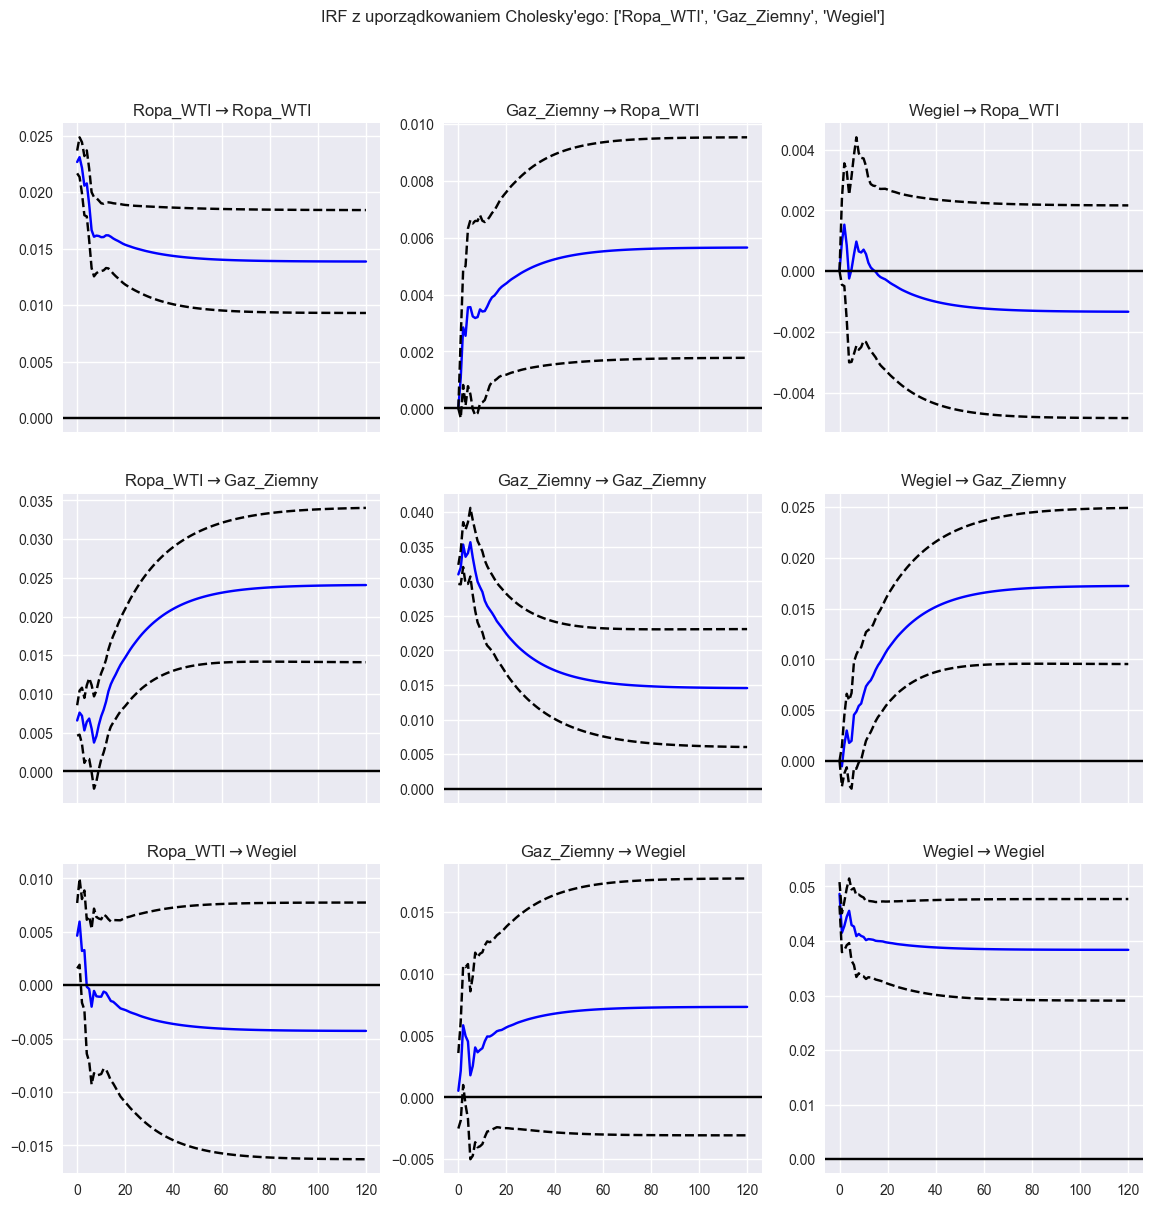

In [59]:
print("\n=== FUNKCJE ODPOWIEDZI NA IMPULS (IRF) ===")
corr_matrix = vecm.resid
corr_matrix = pd.DataFrame(corr_matrix, columns=log_dane.columns).corr()
print("Macierz korelacji reszt:")
print(corr_matrix)

new_order = ['Ropa_WTI', 'Gaz_Ziemny', 'Wegiel']
ordered_data = log_dane[new_order]

# Ponowna estymacja modelu na uporządkowanych danych
model_ordered = VECM(ordered_data, k_ar_diff=vecm.k_ar - 1, coint_rank=ranga3, deterministic="ci")
vecm_ordered_res = model_ordered.fit()

print(f"\nModel przeliczony dla kolejności Cholesky'ego: {new_order}")

# 3. IRF na uporządkowanych danych
irf_analysis = vecm_ordered_res.irf(periods=120)

plt.figure(figsize=(12, 12))
# Teraz orth=True zastosuje Cholesky'ego w kolejności Ropa -> Gaz -> Węgiel
irf_analysis.plot(orth=True, repl=1000, signif=0.05, figsize=(12, 12))
plt.suptitle(f'IRF z uporządkowaniem Cholesky\'ego: {new_order}', y=1.02)
plt.show()
